# Functions

In [194]:
!pip install seaborn

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression  
import seaborn as sns 

def soft_histogram(column, bins=30, bw_method='scott'):
    """
    Plots a soft histogram (Kernel Density Estimation) for a given column.
    
    Args:
        column (pd.Series): The DataFrame column to plot.
        bins (int): Number of bins for the traditional histogram.
        bw_method (str or float): Bandwidth method for KDE ('scott', 'silverman', or float).
    """
    data = column.dropna().values  # Remove NaNs and convert to array

    # KDE Calculation
    kde = gaussian_kde(data, bw_method=bw_method)
    x = np.linspace(min(data), max(data), 1000)  # Range for the KDE curve

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(x, kde(x), label="Soft Histogram (KDE)", linewidth=2)
    plt.hist(data, bins=bins, density=True, alpha=0.3, label="Traditional Histogram")
    plt.title("Soft Histogram Using KDE")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


In [196]:
## Linear Regression with scikit-learning (a function)

def linear_regression(X, y):
    """
    Fits a linear regression model to the data.
    
    Args:
        X (pd.DataFrame): The independent variables.
        y (pd.Series): The dependent variable.
    
    Returns:
        model (LinearRegression): The fitted model.
    """
    model = LinearRegression()
    model.fit(X, y)
    return model

## Calculamos el percentil medio por usuario en los simulacros

El percentil promedio en los simulacros será nuestra variable a predecir. Posteriormente estudiaremos quienes serán nuestras variables predictoras. La finalidad es encontrar el mejor modelo que pueda predecir el percentil de un usuario en un posible examen oficial (o simulacro). Pasos:

1. Obtención de la tabla desagregada de todas las preguntas unidas a todos los usuarios, en dicha tabla tengo que poder encontrar
    - Todas las preguntas individuales realizadas por un usuario,
    - De cada una de las preguntas tengo que poder tener acceso
        - Dificultad de la pregunta
        - Categoría de la pregunta
        - Tema de la pregunta
        - Número de personas que han repondido a dicha pregutna
2. Estudio de la tendencias por diferentes estratos:
    - Realizar agrupaciones por tema:
        - Sumar el número de respuestas correctas e incorrectas en cada tema $i-ésimo$
        - Seguidamente realizar agrupaciones por usuario y calcular la variale improve (tendencia general)
            - Agrupamos por día y calculamos:
                $$
                (improve)_i= \frac{(correctas)_i-(incorrectas_i)*p}{(total)_i}
                $$
            - Promediamos y calculamos la variable improve_by_chapter:
    - Realizar agrupaciones por dificultad (se estiman 4 tipos):
        - Sumar el número de respuestas correctas e incorrectas en cada estrato
        - Realizar agrupacioens por día y calcular la vaiable imporve\_by\_difficult en cada estrato
        - Promediar
    - Realizar agrupaciones por categoría (hay 3 categorías):
        - Sumar el número de respuestas correctas e incorrectas en cada estrato
        - Realizar agrupacioens por usuarios y calcular la variable improve\_by\_category en cada categoría
        - Promediar

3. Estudio del rendimiento en simulacros:
    - Obtenemos las notas y percentiles de los usuarios en cada simulacro
    - Agrupamos y promediamos percentil
    - Creamos una nueva variable que nos indique si el usuario es Apto o no.
        - Un criterio podría ser, si el usuario ha realizado +2 simulacros y su percentil > 0.7.
        

# 0. Carga de los datos

In [197]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import jenkspy

In [198]:
# Loading the data from the csv file

questions = pd.read_csv('questions.csv')
ranking_specials = pd.read_csv('ranking_specials.csv')
topics = pd.read_csv('topics.csv')
user_test_answers = pd.read_csv('user_test_answers.csv')
users = pd.read_csv('users.csv')
breaks = pd.read_csv('breaks.csv')

## 1. Tabla de respuestas de usuarios

In [199]:
# Study the shape of the user_Test_answerd data
user_test_answers.head()

,userId,questionId,score,answer,updatedAt
0,8115,202009180114,-1,1.0,2024-11-28T21:58:54.760378
1,8115,202211170302,1,3.0,2024-11-28T21:58:54.760378
2,8115,202208120124,1,2.0,2024-11-28T21:58:54.760378
3,8115,202212310321,1,3.0,2024-11-28T21:58:54.760378
4,8115,202301020302,-1,3.0,2024-11-28T21:58:54.760378


In [200]:
users

,id,username,totalQuestions,rightQuestions,wrongQuestions,createdAt,updatedAt,goal,goalDate,goalWeek,enabled,lastUsed,isPremium,tutorial
0,806,Mick,10,4,6,2022-11-29T08:10:19.638049+00:00,2022-11-29T08:10:19.638049+00:00,10.0,2022-11-28T00:00:00.000246+00:00,NaN,True,NaN,False,False
1,805,MarinaL,20,3,17,2022-11-29T07:25:09.849273+00:00,2022-11-29T07:25:09.849273+00:00,20.0,2022-11-28T00:00:00.000197+00:00,NaN,True,NaN,False,False
2,796,Lauradub,0,0,0,2022-11-28T17:26:01.948714+00:00,2022-11-28T17:26:01.948714+00:00,0.0,2022-11-28T00:00:00.000454+00:00,NaN,True,NaN,False,False
3,795,tukiresulona,10,4,6,2022-11-28T17:20:15.262594+00:00,2022-11-28T17:20:15.262594+00:00,10.0,2022-11-28T00:00:00.000421+00:00,NaN,True,NaN,False,False
4,53,Marta.Ponce,10,0,10,2022-11-28T14:14:45.673785+00:00,2022-11-28T14:14:45.673785+00:00,0.0,2024-08-26T00:00:00.000904+00:00,140.0,True,NaN,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9144,10953,JaviLL,0,0,0,2024-12-14T12:33:57.185256+00:00,2024-12-14T12:33:57.185256+00:00,0.0,2024-12-09T00:00:00.000781+00:00,140.0,True,NaN,False,True
9145,10949,eRioL,0,0,0,2024-12-13T16:09:47.255825+00:00,2024-12-13T16:09:47.255825+00:00,0.0,2024-12-09T00:00:00.000024+00:00,140.0,True,NaN,False,True
9146,10939,8iivan,0,0,0,2024-12-13T15:39:19.651892+00:00,2024-12-13T15:39:19.651892+00:00,0.0,2024-12-09T00:00:00.000315+00:00,140.0,True,2024-12-13T00:00:00+00:00,False,True
9147,10913,pr41,210,125,50,2024-12-10T21:34:21.011414+00:00,2024-12-10T21:34:21.011414+00:00,210.0,2024-12-09T00:00:00.000147+00:00,350.0,True,2024-12-13T00:00:00+00:00,False,True


In [201]:
# Merge user data:
def merge():
        # Unir preguntas con temas (topics)
    question_topics = questions[['id', 'topic','category','num_answered','difficult_rate','difficult_unique_rate']].merge(
        topics[['id', 'category', 'name','count_participants','avg_score']],
        left_on='topic', 
        right_on='id', 
        how='left',
        suffixes=('_question', '_topic')  # Controlar sufijos
    )

    # Unir respuestas de usuario con preguntas y temas
    question_topic_answers = user_test_answers[['userId','questionId','score','updatedAt']].merge(
        question_topics, 
        left_on='questionId', 
        right_on='id_question', 
        how='left',
        suffixes=('_answer', '_merged')  # Controlar sufijos
    )

    # Unir con la tabla de usuarios
    user_test_answers_merged = question_topic_answers.merge(
        users[['id', 'username', 'lastUsed', 'isPremium']], 
        left_on='userId', 
        right_on='id', 
        how='left',
        suffixes=('_final', '_user')  # Controlar sufijos
    )

    '''
    # join with aptos_merged
    user_test_answers_merged = user_test_answers_merged.merge(
        users_aptos_merged[['userId', 'apto_score_normalized', 'rightRate']],
        left_on='userId',
        right_on='userId',
        how='left'
        
    )
    '''


    # Renombrar columnas para mayor claridad
    user_test_answers_merged = user_test_answers_merged.rename(columns={
        'name': 'topic_name',
        'category': 'topic_category',
        'id_question': 'question_id',
        'id_topic': 'topic_id',
        'updatedAt_answer': 'updated_at_answer',
        'updatedAt_user': 'updated_at_user'
    })

    return user_test_answers_merged




# Mostrar el resultado
user_test_answers_v2 = merge()


In [202]:
user_test_answers_v2.columns

Index(['userId', 'questionId', 'score', 'updatedAt', 'question_id', 'topic',
       'category_question', 'num_answered', 'difficult_rate',
       'difficult_unique_rate', 'topic_id', 'category_topic', 'topic_name',
       'count_participants', 'avg_score', 'id', 'username', 'lastUsed',
       'isPremium'],
      dtype='object')

# 2. Estudio de la tendencia

## 2.1 Estudio de los rangos de dificultades

In [203]:
# Remove the nex Columns
user_test_answers_final = user_test_answers_v2.drop(
    columns=
    ['questionId', 'question_id', 'category_topic', 'topic_name', 'id'])

# Change category 1->Derecho, 2-> Sociología, 3-> Técnico
user_test_answers_final['category_question'] = user_test_answers_final['category_question'].replace(
    {1: 'Derecho', 2: 'Sociología', 3: 'Técnico'})
user_test_answers_final.head()

,userId,score,updatedAt,topic,category_question,num_answered,difficult_rate,difficult_unique_rate,topic_id,count_participants,avg_score,username,lastUsed,isPremium
0,8115,-1,2024-11-28T21:58:54.760378,9.0,Derecho,587.0,0.105622,1.000000e-07,9.0,0.0,NaN,pativelver,2024-12-13T00:00:00+00:00,True
1,8115,1,2024-11-28T21:58:54.760378,17.0,Derecho,545.0,0.124771,1.000000e-07,17.0,0.0,NaN,pativelver,2024-12-13T00:00:00+00:00,True
2,8115,1,2024-11-28T21:58:54.760378,31.0,Sociología,342.0,0.247369,1.000000e-07,31.0,0.0,NaN,pativelver,2024-12-13T00:00:00+00:00,True
3,8115,1,2024-11-28T21:58:54.760378,45.0,Técnico,366.0,0.133880,1.000000e-07,45.0,0.0,NaN,pativelver,2024-12-13T00:00:00+00:00,True
4,8115,-1,2024-11-28T21:58:54.760378,24.0,Derecho,366.0,0.101093,1.000000e-07,24.0,0.0,NaN,pativelver,2024-12-13T00:00:00+00:00,True


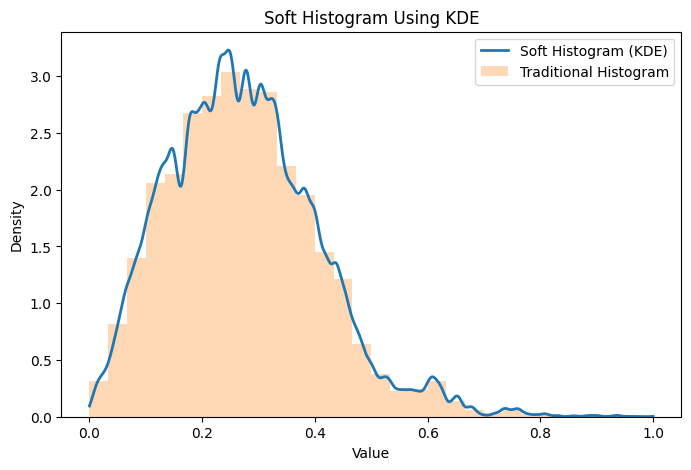

In [204]:
# soft Hist of the dificult rate
soft_histogram(user_test_answers_final['difficult_rate'], bins=30, bw_method='scott')

Usando el algorimo de K-means podemos hacer agrupacioens automáticas no parametrizadas de los datos
en tantos grupos como digamos.

In [205]:
# Take 1/4 of the set
user_test_answers_final_quarter = user_test_answers_final.sample(frac=0.2)

user_test_answers_final_quarter.shape

(620369, 14)

In [206]:

breaks = jenkspy.jenks_breaks(user_test_answers_final_quarter['difficult_rate'].dropna(), n_classes=5, )
print("Cortes de subgrupos:", breaks)



Cortes de subgrupos: [np.float64(1e-07), np.float64(0.160344927586207), np.float64(0.263934526229508), np.float64(0.368312857201646), np.float64(0.519005947953216), np.float64(1.0000001)]


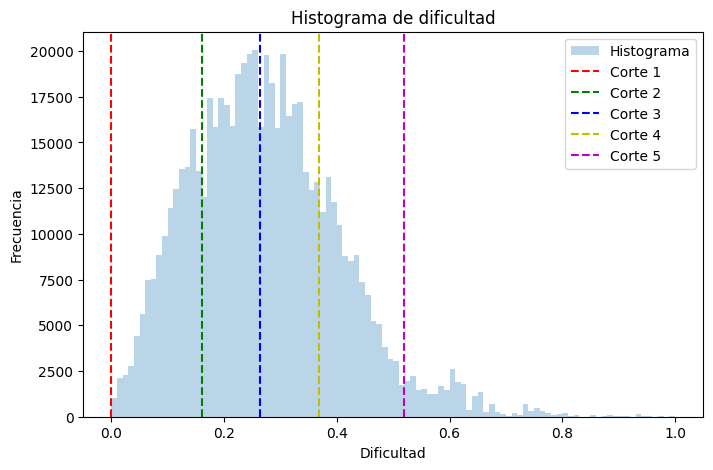

In [207]:
# plot the breaks and the histogram

plt.figure(figsize=(8, 5))

plt.hist(user_test_answers_final_quarter['difficult_rate'], bins=100, alpha=0.3, label="Histograma")
plt.title("Histograma de dificultad")
plt.xlabel("Dificultad")
plt.ylabel("Frecuencia")
plt.axvline(breaks[0], color='r', linestyle='--', label='Corte 1')
plt.axvline(breaks[1], color='g', linestyle='--', label='Corte 2')
plt.axvline(breaks[2], color='b', linestyle='--', label='Corte 3')
plt.axvline(breaks[3], color='y', linestyle='--', label='Corte 4')
plt.axvline(breaks[4], color='m', linestyle='--', label='Corte 5')

plt.legend()
plt.show()


In [208]:
# save the breaks in a cvs file
breaks = pd.DataFrame(breaks)
breaks.to_csv('breaks.csv', index=False)


In [209]:
# from dataFrame to list
breaks_list = breaks[0]
breaks_list = breaks_list.tolist()

## 2.2 Clasificación y agrupación por rangos de dificultad

In [210]:
breaks_list

[1e-07,
 0.160344927586207,
 0.263934526229508,
 0.368312857201646,
 0.519005947953216,
 1.0000001]

In [211]:
# Classification by dificult rate
# Create a new column with the classification
def classify_difficult_rate(difficult_rate):
    if difficult_rate < breaks_list[0]:
        return 'So easy'
    elif difficult_rate < breaks_list[1]:
        return 'easy'
    elif difficult_rate < breaks_list[2]:
        return 'Normal'
    elif difficult_rate < breaks_list[3]:
        return 'Hard'
    else:
        return 'So hard'
    
user_test_answers_final['difficult_rate_class'] = user_test_answers_final['difficult_rate'].apply(classify_difficult_rate)

user_test_answers_final.head()

,userId,score,updatedAt,topic,category_question,num_answered,difficult_rate,difficult_unique_rate,topic_id,count_participants,avg_score,username,lastUsed,isPremium,difficult_rate_class
0,8115,-1,2024-11-28T21:58:54.760378,9.0,Derecho,587.0,0.105622,1.000000e-07,9.0,0.0,NaN,pativelver,2024-12-13T00:00:00+00:00,True,easy
1,8115,1,2024-11-28T21:58:54.760378,17.0,Derecho,545.0,0.124771,1.000000e-07,17.0,0.0,NaN,pativelver,2024-12-13T00:00:00+00:00,True,easy
2,8115,1,2024-11-28T21:58:54.760378,31.0,Sociología,342.0,0.247369,1.000000e-07,31.0,0.0,NaN,pativelver,2024-12-13T00:00:00+00:00,True,Normal
3,8115,1,2024-11-28T21:58:54.760378,45.0,Técnico,366.0,0.133880,1.000000e-07,45.0,0.0,NaN,pativelver,2024-12-13T00:00:00+00:00,True,easy
4,8115,-1,2024-11-28T21:58:54.760378,24.0,Derecho,366.0,0.101093,1.000000e-07,24.0,0.0,NaN,pativelver,2024-12-13T00:00:00+00:00,True,easy


In [212]:
# save the data in a cvs file
user_test_answers_final.to_csv('user_test_answers_final.csv', index=False)

In [213]:
# Group by difficulty rate class

user_test_answer_by_difficult = user_test_answers_final.groupby(['difficult_rate_class', 'userId']).agg(
    total=('score', 'count'),
    totalUnanswered=('score', lambda x: (x == 0).sum()), 
    totalCorrect=('score', lambda x: (x == 1).sum()),
    totalIncorrect=('score', lambda x: (x == -1).sum()),
    meanDifficulty=('difficult_rate', 'mean'),
    meanScore=('score', 'mean'),
).reset_index()

In [214]:
user_test_answer_by_difficult.head(10)

user_test_answer_by_difficult.sort_values(by='totalCorrect', ascending=False).head(10)

,difficult_rate_class,userId,total,totalUnanswered,totalCorrect,totalIncorrect,meanDifficulty,meanScore
7433,Normal,2807,25321,702,22012,2607,0.214157,0.766360
19492,easy,2807,20625,328,19522,775,0.105790,0.908945
1326,Hard,2807,19310,1021,14778,3511,0.311318,0.583480
10733,Normal,8159,10576,61,10166,349,0.213422,0.928234
22509,easy,8159,9479,38,9352,89,0.106850,0.977213
13537,So hard,2807,13887,1064,8843,3980,0.467869,0.350184
7667,Normal,3211,10827,653,8816,1358,0.210630,0.688833
4595,Hard,8159,8001,70,7365,566,0.310267,0.849769
20805,easy,5019,7821,520,7092,209,0.104902,0.880066
8824,Normal,5019,9175,1602,6938,635,0.213393,0.686975


In [215]:
# Create a mark for each type of difficulty

def get_mark(totalCorrect, totalIncorrect, totalUnanswered):
    total = totalCorrect + totalIncorrect + totalUnanswered
    if total == 0:
        return 0  # Evitar división por cero
    return (totalCorrect - totalIncorrect * 0.2) * 10 / total

# group by user adding the mark

user_test_answer_by_difficult['markDifficult'] = user_test_answer_by_difficult.apply(
    lambda x: get_mark(x['totalCorrect'], x['totalIncorrect'], x['totalUnanswered']), axis=1)

user_test_answer_by_difficult.head(10)


,difficult_rate_class,userId,total,totalUnanswered,totalCorrect,totalIncorrect,meanDifficulty,meanScore,markDifficult
0,Hard,1,115,111,1,3,0.316648,-0.017391,0.034783
1,Hard,6,9,6,3,0,0.301401,0.333333,3.333333
2,Hard,8,3,0,1,2,0.298530,-0.333333,2.000000
3,Hard,11,66,15,29,22,0.319032,0.106061,3.727273
4,Hard,13,137,16,89,32,0.315190,0.416058,6.029197
5,Hard,14,21,0,4,17,0.304483,-0.619048,0.285714
6,Hard,23,10,4,3,3,0.307655,0.000000,2.400000
7,Hard,26,144,141,2,1,0.308857,0.006944,0.125000
8,Hard,35,422,140,172,110,0.314447,0.146919,3.554502
9,Hard,37,20,4,5,11,0.312064,-0.300000,1.400000


In [216]:
# group by user adding the mark

user_summary_difficult = user_test_answer_by_difficult.groupby('userId').agg(
    total=('total', 'sum'),
    totalUnanswered=('totalUnanswered', 'sum'),
    totalCorrect=('totalCorrect', 'sum'),
    totalIncorrect=('totalIncorrect', 'sum'),
    meanDifficulty=('meanDifficulty', 'mean'),
    meanScore=('meanScore', 'mean'),
    easyMark=('markDifficult', lambda x: x[user_test_answer_by_difficult['difficult_rate_class'] == 'easy'].mean()),
    mediumMark=('markDifficult', lambda x: x[user_test_answer_by_difficult['difficult_rate_class'] == 'Normal'].mean()),
    hardMark=('markDifficult', lambda x: x[user_test_answer_by_difficult['difficult_rate_class'] == 'Hard'].mean()),
    veryHardMark=('markDifficult', lambda x: x[user_test_answer_by_difficult['difficult_rate_class'] == 'So hard'].mean()),
    markDifficult=('markDifficult', 'mean')
).reset_index()

In [217]:
user_summary_difficult = user_summary_difficult[user_summary_difficult['total']>100]
user_summary_difficult.sort_values(by='veryHardMark', ascending=False).head(10)

,userId,total,totalUnanswered,totalCorrect,totalIncorrect,meanDifficulty,meanScore,easyMark,mediumMark,hardMark,veryHardMark,markDifficult
4661,8159,33525,250,31539,1736,0.274522,0.868178,9.847241,9.546331,9.063617,8.245749,9.175735
5462,9965,620,0,565,55,0.267987,0.802177,9.425532,8.944444,8.717557,8.164706,8.813060
1052,2329,220,9,191,20,0.275832,0.793706,8.666667,9.058824,9.507246,7.406593,8.659832
82,337,300,10,251,39,0.275917,0.835401,10.000000,9.739130,9.134021,6.915033,8.947046
2896,5240,290,26,229,35,0.276767,0.680677,8.000000,7.631579,8.312500,6.833333,7.694353
4346,7340,8825,248,7281,1296,0.272859,0.630386,8.771194,7.634207,7.531707,6.797765,7.683719
266,928,290,26,232,32,0.275072,0.766616,10.000000,8.783784,7.833333,6.735849,8.338242
3398,5929,120,10,94,16,0.279554,0.782541,10.000000,8.888889,8.067797,6.705882,8.415642
1310,2750,690,33,551,106,0.276079,0.670193,8.775510,8.321739,7.677725,6.670000,7.861244
125,573,200,3,161,36,0.275812,0.750000,10.000000,9.454545,7.750000,6.659091,8.465909


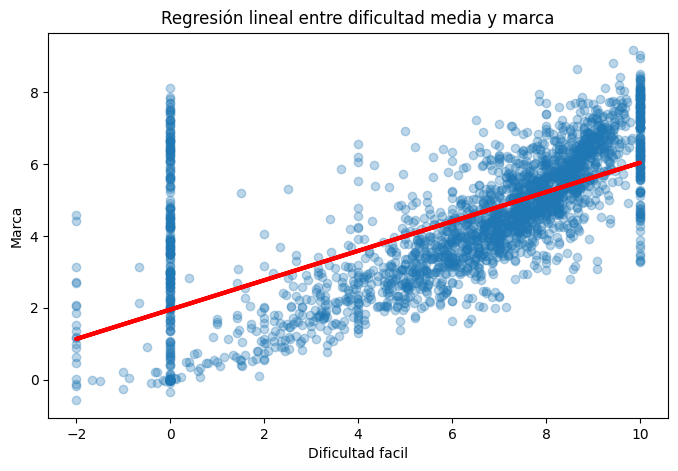

In [218]:
user_summary_difficult.fillna({'easyMark': 0, 'mediumMark': 0, 'hardMark': 0, 'veryHardMark': 0, 'veryEasyMark': 0}, inplace=True)
user_summary_difficult.dropna(subset= ['easyMark'], thresh=0, inplace=True)
lm1 = linear_regression(user_summary_difficult[['easyMark']], user_summary_difficult['markDifficult'])
# plot the regression line
plt.figure(figsize=(8, 5))
plt.scatter(user_summary_difficult['easyMark'], user_summary_difficult['markDifficult'], alpha=0.3)
plt.plot(user_summary_difficult['easyMark'], lm1.predict(user_summary_difficult[['easyMark']]), color='red', linewidth=3)
plt.title("Regresión lineal entre dificultad media y marca")
plt.xlabel("Dificultad facil")
plt.ylabel("Marca")
plt.show()

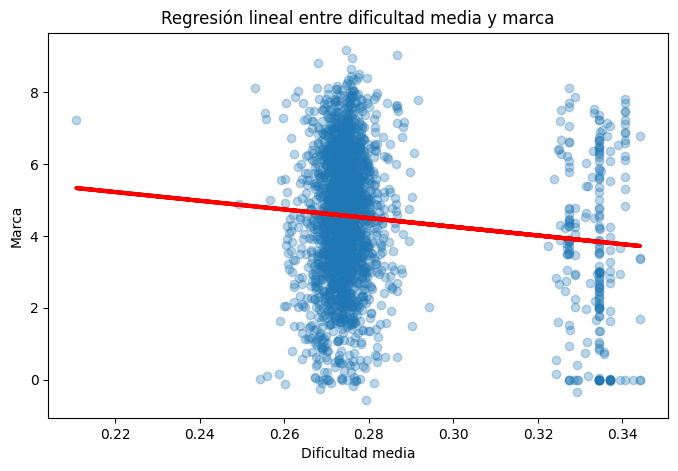

In [220]:

lm2 = linear_regression(user_summary_difficult[['meanDifficulty']], user_summary_difficult['markDifficult'])
# plot the regression line
plt.figure(figsize=(8, 5))
plt.scatter(user_summary_difficult['meanDifficulty'], user_summary_difficult['markDifficult'], alpha=0.3)
plt.plot(user_summary_difficult['meanDifficulty'], lm2.predict(user_summary_difficult[['meanDifficulty']]), color='red', linewidth=3)
plt.title("Regresión lineal entre dificultad media y marca")
plt.xlabel("Dificultad media")
plt.ylabel("Marca")
plt.show()


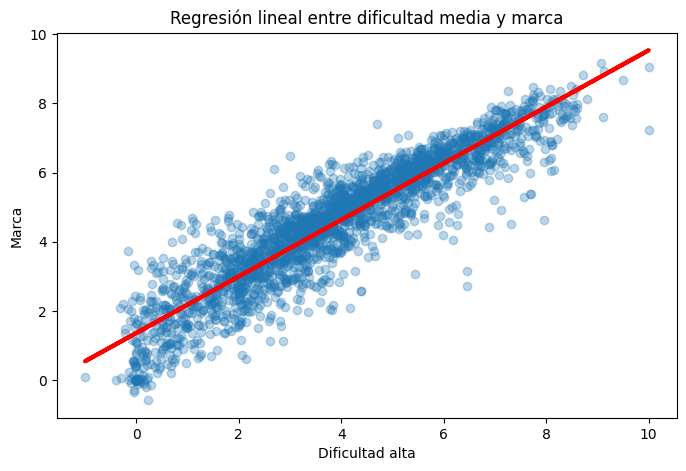

In [222]:

lm3 = linear_regression(user_summary_difficult[['hardMark']], user_summary_difficult['markDifficult'])
# plot the regression line
plt.figure(figsize=(8, 5))
plt.scatter(user_summary_difficult['hardMark'], user_summary_difficult['markDifficult'], alpha=0.3)
plt.plot(user_summary_difficult['hardMark'], lm3.predict(user_summary_difficult[['hardMark']]), color='red', linewidth=3)
plt.title("Regresión lineal entre dificultad media y marca")
plt.xlabel("Dificultad alta")
plt.ylabel("Marca")
plt.show()

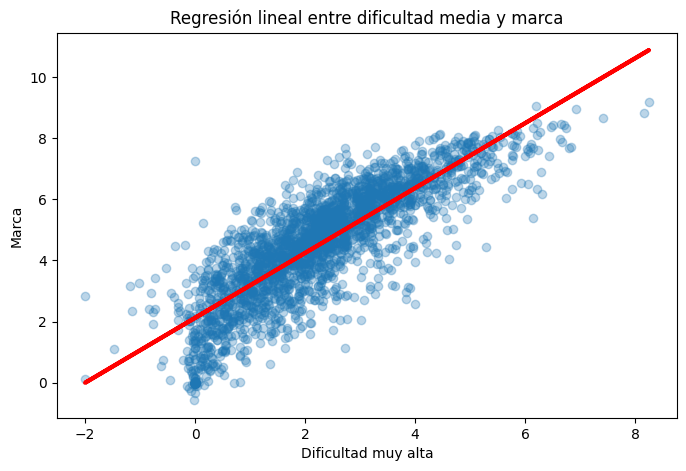

In [224]:
lm4 = linear_regression(user_summary_difficult[['veryHardMark']], user_summary_difficult['markDifficult'])
# plot the regression line
plt.figure(figsize=(8, 5))
plt.scatter(user_summary_difficult['veryHardMark'], user_summary_difficult['markDifficult'], alpha=0.3)
plt.plot(user_summary_difficult['veryHardMark'], lm4.predict(user_summary_difficult[['veryHardMark']]), color='red', linewidth=3)
plt.title("Regresión lineal entre dificultad media y marca")
plt.xlabel("Dificultad muy alta")
plt.ylabel("Marca")
plt.show()

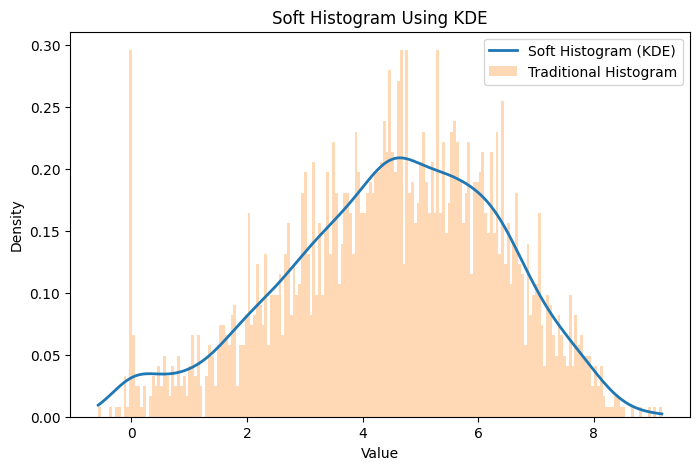

In [225]:
#plot a histogram of the mark
soft_histogram(user_summary_difficult['markDifficult'], bins=200, bw_method='scott')


# 2. Estudio por categorías 

In [226]:
user_test_answers_final.columns

Index(['userId', 'score', 'updatedAt', 'topic', 'category_question',
       'num_answered', 'difficult_rate', 'difficult_unique_rate', 'topic_id',
       'count_participants', 'avg_score', 'username', 'lastUsed', 'isPremium',
       'difficult_rate_class'],
      dtype='object')

In [227]:
# Group by category

user_test_answer_by_category = user_test_answers_final.groupby(['category_question', 'userId']).agg(
    total=('score', 'count'),
    totalUnanswered=('score', lambda x: (x == 0).sum()), 
    totalCorrect=('score', lambda x: (x == 1).sum()),
    totalIncorrect=('score', lambda x: (x == -1).sum()),
    meanScore=('score', 'mean'),
).reset_index()


In [229]:
user_test_answer_by_category.head(2)

,category_question,userId,total,totalUnanswered,totalCorrect,totalIncorrect,meanScore
0,Derecho,1,546,543,1,2,-0.001832
1,Derecho,6,17,12,3,2,0.058824


In [230]:
# Create a mark for each type of category

def get_mark(totalCorrect, totalIncorrect, totalUnanswered):
    total = totalCorrect + totalIncorrect + totalUnanswered
    if total == 0:
        return 0  # Evitar división por cero
    return (totalCorrect - totalIncorrect * 0.2) * 10 / total

# group by user adding the mark

user_test_answer_by_category['markByCategory'] = user_test_answer_by_category.apply(
    lambda x: get_mark(x['totalCorrect'], x['totalIncorrect'], x['totalUnanswered']), axis=1)

user_test_answer_by_category.head(2)


,category_question,userId,total,totalUnanswered,totalCorrect,totalIncorrect,meanScore,markByCategory
0,Derecho,1,546,543,1,2,-0.001832,0.010989
1,Derecho,6,17,12,3,2,0.058824,1.529412


In [231]:
# group by user adding the markByCategory

user_summary_category = user_test_answer_by_category.groupby('userId').agg(
    total=('total', 'sum'),
    totalUnanswered=('totalUnanswered', 'sum'),
    totalCorrect=('totalCorrect', 'sum'),
    totalIncorrect=('totalIncorrect', 'sum'),
    meanScore=('meanScore', 'mean'),
    derecho=('markByCategory', lambda x: x[user_test_answer_by_category['category_question'] == 'Derecho'].mean()),
    sociologia=('markByCategory', lambda x: x[user_test_answer_by_category['category_question'] == 'Técnico'].mean()),
    tecnico=('markByCategory', lambda x: x[user_test_answer_by_category['category_question'] == 'Sociología'].mean()),
    markCategory=('markByCategory', 'mean')
).reset_index()

In [232]:
# Create a user_summary joining the two summaries

user_summary = user_summary_difficult.merge(
    user_summary_category,
    on='userId',
    how='left',
    suffixes=('_difficult', '_category')
)

In [233]:
user_summary.head(2)

,userId,total_difficult,totalUnanswered_difficult,totalCorrect_difficult,totalIncorrect_difficult,meanDifficulty,meanScore_difficult,easyMark,mediumMark,hardMark,...,markDifficult,total_category,totalUnanswered_category,totalCorrect_category,totalIncorrect_category,meanScore_category,derecho,sociologia,tecnico,markCategory
0,1,639,610,8,21,0.267200,-0.022533,0.094675,0.059925,0.034783,...,0.053027,605.0,601.0,1.0,3.0,-0.006783,0.010989,0.000000,-0.037037,-0.008683
1,11,285,32,187,66,0.274194,0.350141,9.209302,6.447059,3.727273,...,5.637575,285.0,32.0,187.0,66.0,0.482778,5.848889,7.033333,NaN,6.441111


# 3. Estudio de la nota de los simulacros

In [234]:

ranking_specials_merged = ranking_specials.merge(users['id'], left_on='userId', right_on='id', how='left')
ranking_specials_merged = ranking_specials.merge(topics[['id', 'isMock']], left_on='specialTopic', right_on='id', how='left')
ranking_specials_merged = ranking_specials_merged[ranking_specials_merged['isMock'] == True]
ranking_specials_merged.head(3)


,userId,username,specialTopic,specialTopicRank,rightQuestions,wrongQuestions,totalQuestions,score,timeSpentMillis,percentile,total,avg,updatedAt,id,isMock
8338,928,JuanmaG,132,1,90,5,100,8.75,2584000.0,100,555,4.424414,2023-03-11T17:51:45.753915,132,True
8339,337,DavidF,132,2,90,7,100,8.65,2617000.0,100,555,4.424414,2023-04-10T15:39:59.926553,132,True
8340,6728,Kat,132,3,86,3,100,8.45,2566000.0,100,555,4.424414,2024-03-07T00:33:22.082199,132,True


In [235]:
user_ranking = ranking_specials_merged.groupby('userId').agg(
    percentileMean=('percentile', lambda x: np.mean(x)/100),
    totalMoks= ('userId','count'),
    totalCorrectInMock=('rightQuestions', 'sum'),
    totalIncorrectInMock=('wrongQuestions', 'sum'),
    meanScoreInMock=('score', 'mean'),
    distFromMean=('score', lambda x: (x - ranking_specials_merged['avg'].reindex(x.index)).mean())
).reset_index()


In [236]:

# Only users with more than 30 questions
user_ranking = user_ranking[user_ranking['totalCorrectInMock'] + user_ranking['totalIncorrectInMock'] > 30]
# Only people with 
user_ranking.head(10)

,userId,percentileMean,totalMoks,totalCorrectInMock,totalIncorrectInMock,meanScoreInMock,distFromMean
1,35,0.505000,2,95,39,3.775000,0.237287
2,48,0.940000,1,75,8,7.100000,3.162486
3,54,0.665385,13,766,247,4.942308,0.988804
4,64,0.247500,8,308,211,2.531250,-1.428547
5,73,0.235000,2,85,65,2.625000,-1.895165
6,75,0.933333,3,235,33,7.283333,2.825384
7,85,0.735000,2,120,33,5.175000,1.637287
8,90,0.371667,6,328,222,3.616667,-0.365681
9,104,0.853333,3,216,46,6.433333,2.762353
10,134,0.535000,2,106,52,4.000000,0.462287


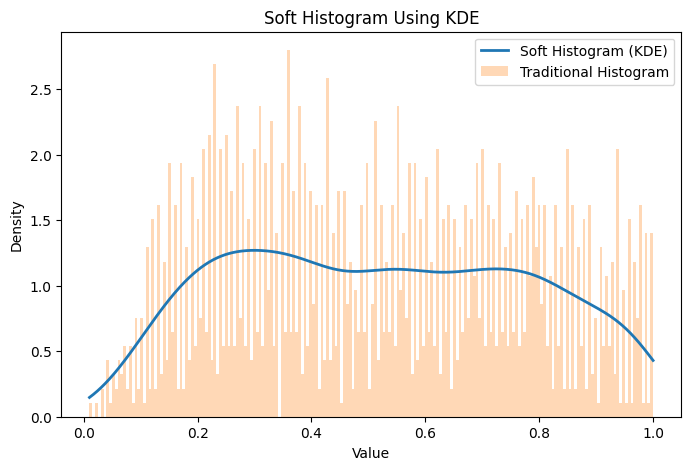

In [237]:
# hist of the mean score in the mock

soft_histogram(user_ranking['percentileMean'], bins=200, bw_method='scott')

In [238]:
users_aptos = user_ranking[(user_ranking['percentileMean'] > 0.70) & (user_ranking['totalMoks'] > 2)]
users_aptos.shape

(155, 7)

In [239]:
# Create a column in user_ranking people with more than 70% of the questions correct and more than 2 mocks is apto

user_ranking['isApto'] = user_ranking['userId'].isin(users_aptos['userId'])
user_ranking.head(3)

,userId,percentileMean,totalMoks,totalCorrectInMock,totalIncorrectInMock,meanScoreInMock,distFromMean,isApto
1,35,0.505000,2,95,39,3.775000,0.237287,False
2,48,0.940000,1,75,8,7.100000,3.162486,False
3,54,0.665385,13,766,247,4.942308,0.988804,False


In [240]:
# join with user_summary
user_summary = user_summary.merge(user_ranking[['userId', 'isApto', 'totalMoks', 'meanScoreInMock', 'distFromMean','percentileMean']], on='userId', how='left')

In [241]:
user_summary.head(3)

,userId,total_difficult,totalUnanswered_difficult,totalCorrect_difficult,totalIncorrect_difficult,meanDifficulty,meanScore_difficult,easyMark,mediumMark,hardMark,...,meanScore_category,derecho,sociologia,tecnico,markCategory,isApto,totalMoks,meanScoreInMock,distFromMean,percentileMean
0,1,639,610,8,21,0.267200,-0.022533,0.094675,0.059925,0.034783,...,-0.006783,0.010989,0.000000,-0.037037,-0.008683,NaN,NaN,NaN,NaN,NaN
1,11,285,32,187,66,0.274194,0.350141,9.209302,6.447059,3.727273,...,0.482778,5.848889,7.033333,NaN,6.441111,NaN,NaN,NaN,NaN,NaN
2,13,510,41,369,100,0.281569,0.480649,8.887097,7.949367,6.029197,...,0.458770,6.443038,6.428571,6.100000,6.323870,NaN,NaN,NaN,NaN,NaN


In [242]:
user_summary_only_mocks = user_summary.copy().dropna(subset=['isApto'])
# rename columns total -> totalQuestions, mark -> meanDifficultyMark

user_summary_only_mocks.rename(columns={'total': 'totalQuestions', 'markDifficult': 'meanDifficultyMark'}, inplace=True)
user_summary_only_mocks.shape

(1463, 26)

In [243]:
user_summary_only_mocks.head(3)

,userId,total_difficult,totalUnanswered_difficult,totalCorrect_difficult,totalIncorrect_difficult,meanDifficulty,meanScore_difficult,easyMark,mediumMark,hardMark,...,meanScore_category,derecho,sociologia,tecnico,markCategory,isApto,totalMoks,meanScoreInMock,distFromMean,percentileMean
5,35,1420,401,698,321,0.272499,0.277840,7.119454,5.157623,3.554502,...,0.271215,4.340828,4.677419,3.924528,4.314259,False,2.0,3.775000,0.237287,0.505000
6,48,530,76,369,85,0.273883,0.536824,9.128205,7.061224,6.741259,...,0.518713,7.168750,6.964706,5.072000,6.401819,False,1.0,7.100000,3.162486,0.940000
7,54,4674,899,2768,1007,0.275122,0.376306,8.416272,6.292793,4.548124,...,0.373939,5.967096,5.663113,4.751037,5.460416,False,13.0,4.942308,0.988804,0.665385


# 4. Matriz de correlación

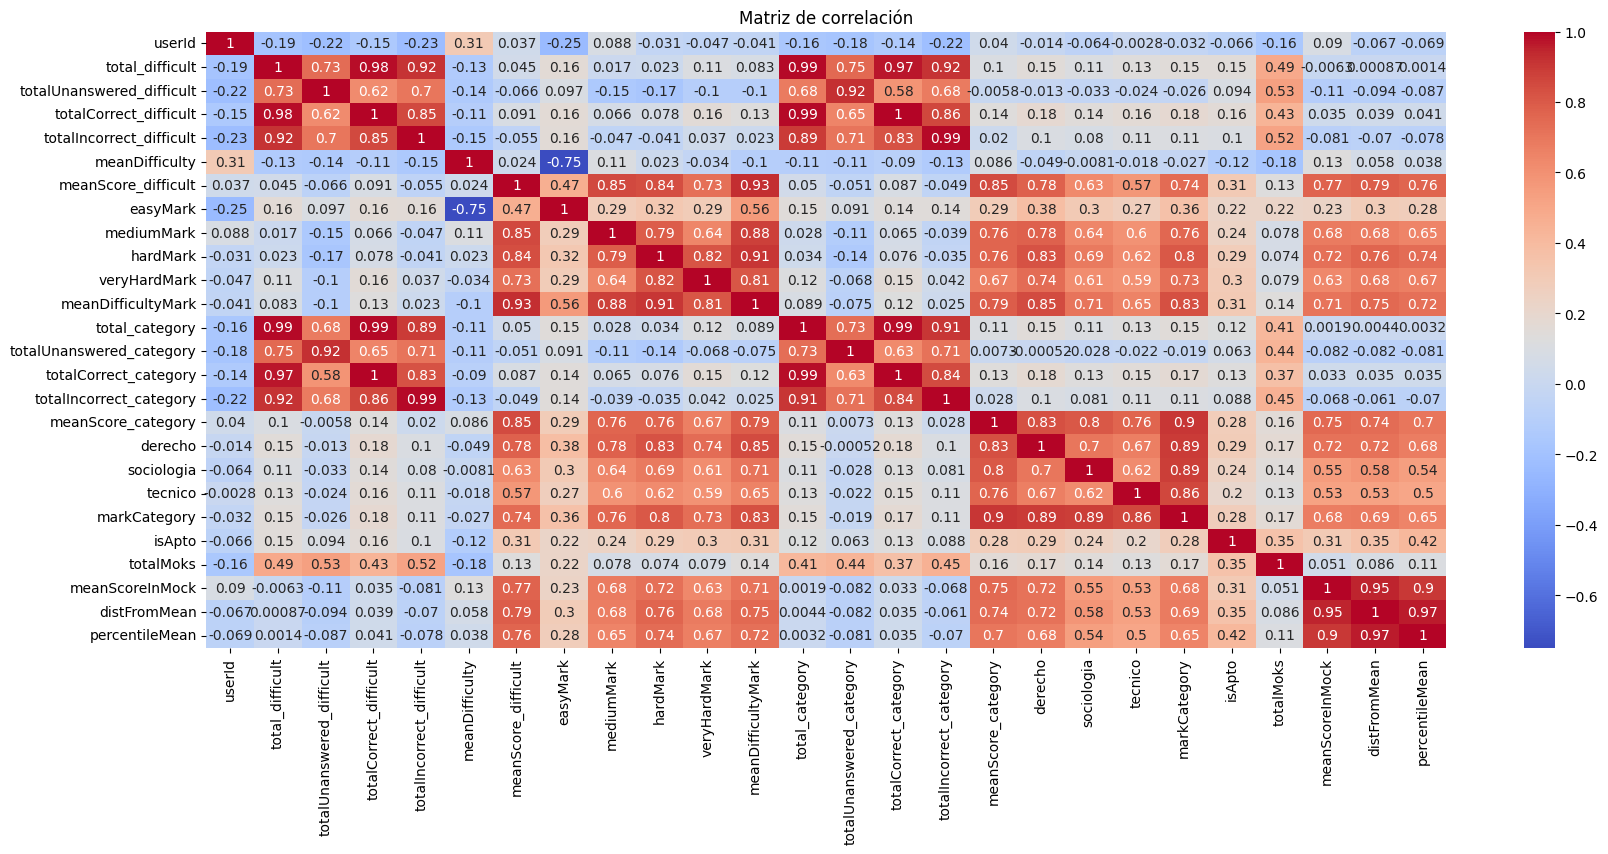

In [245]:
# Correlation matrix of the user_summary_only_mocks with a heat map

plt.figure(figsize=(20, 8))
sns.heatmap(user_summary_only_mocks.corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()



In [246]:
# Save the data in a cvs file

user_summary_only_mocks.to_csv('user_summary_only_mocks.csv', index=False)